# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the AM_MDM and AW_plus_v_AW_neg samples.

# Preliminaries

In [35]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common import trinary_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Data
Data used in the analysis.

In [13]:
DATA = TrinaryData(is_regulator=False, is_dropT1=True, is_averaged=True)
DATA.df_X.head()

,Rv1927,Rv1129c,Rv3085,Rv3083,Rv3086,Rv2226,Rv0260c,Rv1365c,Rv3084,Rv0975c,...,Rv3267,Rv2748c,Rv3260c,Rv0350,Rv2737c,Rv0440--Rv3417c,Rv2734,Rv0519c,Rv3418c,Rv3269
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [67]:
# Not averaged
DATA = TrinaryData(is_regulator=False, is_averaged=True, is_dropT1=True)
DATA.df_X.head()

,Rv1927,Rv1129c,Rv3085,Rv3083,Rv3086,Rv2226,Rv0260c,Rv1365c,Rv3084,Rv0975c,...,Rv3267,Rv2748c,Rv3260c,Rv0350,Rv2737c,Rv0440--Rv3417c,Rv2734,Rv0519c,Rv3418c,Rv3269
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [4]:
DATA.ser_y.head()

timepoint
T2    1
T3    1
T4    1
T5    1
T6    1
Name: name, dtype: int64

# Lab Samples

In [60]:
def sortColumns(df):
    columns = list(df.columns)
    columns.sort()
    df.columns = columns
    df = df.sort_index()
    return df

In [61]:
sample_data = trinary_data.getSampleData(is_regulator=False)
SAMPLE_DCT = {}
for sample in trinary_data.SAMPLES:
    SAMPLE_DCT[sample] = sortColumns(sample_data.__getattribute__(sample))

In [55]:
SAMPLE_DCT.keys()

dict_keys(['AM_MDM', 'AW', 'sherman', 'galagan', 'rustad'])

In [7]:
df_sampleAW = df_sampleAW.T
df_sampleAW.head()

GENE_ID,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AW_plus_1,0,0,0,0,-1,0,-1,0,0,0,...,0,0,-1,0,-1,0,-1,0,0,-1
AW_neg_1,1,1,0,0,-1,1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_3,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,0,-1,-1,-1,-1,-1,-1
AW_neg_3,1,0,0,0,-1,1,0,0,0,0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
AW_plus_4,0,0,0,0,-1,1,0,0,0,0,...,0,0,-1,-1,-1,-1,-1,-1,-1,1


# Classification Validations of Controlled Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


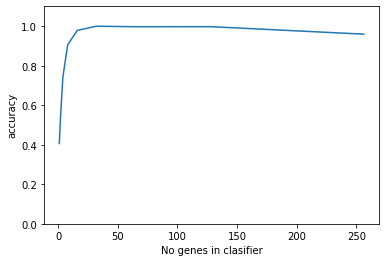

In [86]:
accuracy_dct = {}
for rank in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
        DATA, num_iter=10, num_holdout=1, filter_high_rank=rank, size=100)
plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
plt.ylim([0, 1.1])
_ = plt.xlabel("No genes in clasifier")
_ = plt.ylabel("accuracy")

# Classification of Other Samples

In [79]:
svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=32, size=50)
svm_ensemble.fit(DATA.df_X, DATA.ser_y)

In [83]:
svm_ensemble.predict(sample_dct["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.0,0.00,0.82,0.0,0.18
AM_D20_3,0.0,0.06,0.00,0.0,0.94
AM_D20_4,0.0,0.00,0.94,0.0,0.06
AM_D20_5,0.0,0.00,0.06,0.0,0.94
MDM_D20_1,0.0,1.00,0.00,0.0,0.00
MDM_D20_3,0.0,1.00,0.00,0.0,0.00
MDM_D20_4,0.0,0.00,1.00,0.0,0.00
MDM_D20_5,0.0,0.00,0.00,0.0,1.00


In [85]:
svm_ensemble.predict(sample_dct["AW"])

,0,1,2,3,4
AW_plus_1,0.0,1.0,0.0,0.0,0.0
AW_neg_1,0.0,1.0,0.0,0.0,0.0
AW_plus_3,0.0,1.0,0.0,0.0,0.0
AW_neg_3,0.0,1.0,0.0,0.0,0.0
AW_plus_4,0.0,1.0,0.0,0.0,0.0
AW_neg_4,0.0,1.0,0.0,0.0,0.0
